In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sio
import PIL
from collections import OrderedDict
from pathlib import Path

from dllib.data import\
    ListContainer,\
    ItemList,\
    LabeledData,\
    SplitData,\
    get_dls

from dllib.transforms import ToFloatTensor
from dllib.vision.data import ImageList
from dllib.vision.transforms import ResizeFixed, ToByteTensor, MakeRGB
from dllib.text.processor import TokenProcessor
from dllib.utils import uniqueify

# Data

### read in data 

In [3]:
path = Path("/home/ricky/Desktop/IIIT5K/")
data = sio.loadmat(path/"traindata.mat")
data = data["traindata"][0]
data_images, data_labels = zip(*[(x[0][0], x[1][0]) for x in data])
data_images = [path/name for name in data_images]

In [4]:
for i in range(10):
    print(data_images[i], ",", data_labels[i])

/home/ricky/Desktop/IIIT5K/train/1009_2.png , YOU
/home/ricky/Desktop/IIIT5K/train/1017_1.png , RESCUE
/home/ricky/Desktop/IIIT5K/train/1017_2.png , MISSION
/home/ricky/Desktop/IIIT5K/train/1021_1.png , HOME
/home/ricky/Desktop/IIIT5K/train/1023_1.png , BORDER
/home/ricky/Desktop/IIIT5K/train/1023_10.png , DODA
/home/ricky/Desktop/IIIT5K/train/1023_11.png , BATOTE
/home/ricky/Desktop/IIIT5K/train/1023_15.png , 143KM
/home/ricky/Desktop/IIIT5K/train/1023_16.png , 193KM
/home/ricky/Desktop/IIIT5K/train/1023_17.png , 315KM


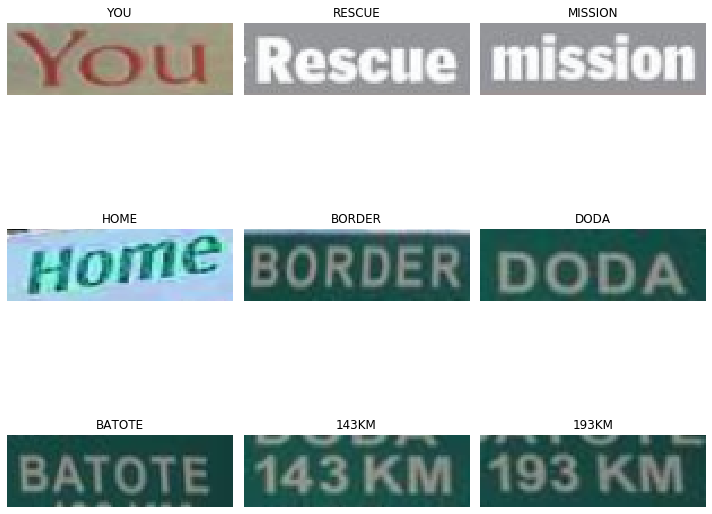

In [5]:
train = ImageList(data_images, path,
                  transforms=[MakeRGB(), ResizeFixed((100, 32))])
fig, axes = plt.subplots(3,3,figsize=(10,10))

for i,ax in enumerate(axes.flatten()):    
    ax.imshow(train[i])
    ax.set_title(data_labels[i])
    ax.set_axis_off()
plt.tight_layout()

### Tokenize response

In [6]:
tp = TokenProcessor()
list(zip(tp(data_labels[:10]), data_labels[:10]))
for i in range(10):
    print("%s, %s, %s" % (data_labels[i],
          tp.encode(data_labels[i]), "".join(tp.decode(tp.encode(data_labels[i])))))

YOU, [1, 2, 3], you
RESCUE, [4, 5, 6, 7, 3, 5], rescue
MISSION, [8, 9, 6, 6, 9, 2, 10], mission
HOME, [11, 2, 8, 5], home
BORDER, [12, 2, 4, 13, 5, 4], border
DODA, [13, 2, 13, 14], doda
BATOTE, [12, 14, 15, 2, 15, 5], batote
143KM, [16, 17, 18, 19, 8], 143km
193KM, [16, 20, 18, 19, 8], 193km
315KM, [18, 16, 21, 19, 8], 315km


In [7]:
tp = TokenProcessor()
train_labels = tp(data_labels)
",".join(tp.vocab)

'-,y,o,u,r,e,s,c,m,i,n,h,b,d,a,t,1,4,3,k,9,5,p,l,g,w,7,0,2,f,v,j,6,z,8,x,q'

### Create train and valid 

In [8]:
def split_data(data_images, data_labels, pvalid=0.2):

    mask = [(np.random.random() > pvalid) for i in range(len(data_images))]

    train_imgs = [data_images[i] for i in range(len(data_images)) if mask[i] == True]
    train_labels = [data_labels[i] for i in range(len(data_images)) if mask[i] == True]

    valid_imgs = [data_images[i] for i in range(len(data_images)) if mask[i] == False]
    valid_labels = [data_labels[i] for i in range(len(data_images)) if mask[i] == False]
    return train_imgs, train_labels, valid_imgs, valid_labels

train_imgs, train_labels, valid_imgs, valid_labels = split_data(data_images, data_labels)

In [9]:
len(train_imgs), len(train_labels), len(valid_imgs), len(valid_labels)

(1616, 1616, 384, 384)

In [10]:
train = LabeledData(
    ImageList(train_imgs, path, transforms=[MakeRGB(), ResizeFixed((100, 32))]),
    ItemList(train_labels, path),
    proc_y=tp,
    )

valid = LabeledData(
    ImageList(valid_imgs, path, transforms=[MakeRGB(), ResizeFixed((100, 32))]),
    ItemList(valid_labels, path),
    proc_y=tp,
    )

In [11]:
train

LabeledData
x: ImageList (1616 items)
[PosixPath('/home/ricky/Desktop/IIIT5K/train/1009_2.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1017_1.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1017_2.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1021_1.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_1.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_10.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_11.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_15.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_16.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_17.png')...]
Path: /home/ricky/Desktop/IIIT5K
y: ItemList (1616 items)
[[1, 2, 3], [4, 5, 6, 7, 3, 5], [8, 9, 6, 6, 9, 2, 10], [11, 2, 8, 5], [12, 2, 4, 13, 5, 4], [13, 2, 13, 14], [12, 14, 15, 2, 15, 5], [16, 17, 18, 19, 8], [16, 20, 18, 19, 8], [18, 16, 21, 19, 8]...]
Path: /home/ricky/Desktop/IIIT5K

In [12]:
valid

LabeledData
x: ImageList (384 items)
[PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_3.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1023_9.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1035_3.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1036_4.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1044_1.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1046_4.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1049_4.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1050_5.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1053_1.png'), PosixPath('/home/ricky/Desktop/IIIT5K/train/1053_3.png')...]
Path: /home/ricky/Desktop/IIIT5K
y: ItemList (384 items)
[[2, 4, 24, 14, 10, 9, 6, 14, 15, 9, 2, 10], [19, 9, 6, 11, 15, 25, 14, 4], [6, 15, 14, 15, 5], [9, 10, 13, 9, 14], [6, 14, 30, 5], [14], [9, 10, 13, 9, 14], [7, 11, 14, 4, 15, 6], [6, 15, 14, 15, 5], [2, 29]...]
Path: /home/ricky/Desktop/IIIT5K

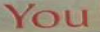

In [13]:
train.x[0]

In [14]:
train.y_obj(0)

['y', 'o', 'u']

In [15]:
train.y[0], tp.decode(train.y[0])

([1, 2, 3], ['y', 'o', 'u'])

In [16]:
data = SplitData(train, valid)
data.train.y[0], data.train.y_obj(0)

([1, 2, 3], ['y', 'o', 'u'])

In [17]:
data.train.x.items[0], data.train.x[0]

(PosixPath('/home/ricky/Desktop/IIIT5K/train/1009_2.png'),
 <PIL.Image.Image image mode=RGB size=100x32 at 0x7F7027443610>)

In [18]:
data.train[0]

(<PIL.Image.Image image mode=RGB size=100x32 at 0x7F7027443490>, [1, 2, 3])

In [19]:
ll = [1, 2,3]

In [20]:
ll.insert(0, 4)

In [21]:
ll

[4, 1, 2, 3]

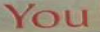

In [22]:
data.train[0][0]

Create the whole dataset in one go

In [23]:
transforms = [MakeRGB(), ResizeFixed((100, 32)), ToByteTensor(), ToFloatTensor()]
tp = TokenProcessor()
_ = tp(data_labels)

image_list = ImageList(data_images, path, transforms=transforms)
train_imgs, train_labels, valid_imgs, valid_labels = split_data(data_images, data_labels)

train = LabeledData(
    ImageList(train_imgs, path, transforms=transforms),
    ItemList(train_labels, path),
    proc_y=tp,
    )

valid = LabeledData(
    ImageList(valid_imgs, path, transforms=transforms),
    ItemList(valid_labels, path),
    proc_y=tp,
    )

data = SplitData(train, valid)

In [24]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [25]:
x, y = data.train[23]

In [26]:
y

[5, 4, 14, 15, 15, 3, 22, 5, 15, 15, 14]

In [27]:
x.shape

torch.Size([3, 32, 100])

In [28]:
"".join(tp.decode(y))

'erattupetta'

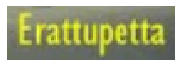

In [29]:
show_image(x)

In [30]:
def pad_collate(samples, pad_idx=-1, pad_first=False):
    max_len = max([len(s[1]) for s in samples])
    res = torch.zeros(len(samples), max_len).long() + pad_idx
    for i,s in enumerate(samples):
        res[i,:len(s[1])] = torch.LongTensor(s[1])
    return torch.cat([s[0].unsqueeze(0) for s in samples], 0), res

In [31]:
from torch.utils.data import DataLoader

In [32]:
dl = DataLoader(data.train, batch_size=4, collate_fn=pad_collate)

In [33]:
iter_dl = iter(dl)
x, y = next(iter_dl)

In [34]:
x.shape, y.shape

(torch.Size([4, 3, 32, 100]), torch.Size([4, 7]))

In [35]:
train_dl, valid_dl = get_dls(data.train, data.valid, 64)

## Model

In [36]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        """
        n_in: size of input vector
        n_hidden: size of output vector
        n_out: output after linear
        """
        super().__init__()
        
        self.rnn = nn.LSTM(n_in, n_hidden, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(n_hidden*2, n_out)
        
    def forward(self, input):
        """
        We take the input image as a series of features and perform
        a lastm bidirectional. We grab the hidden state and do a
        linear transform into size `n_out`
        """
        recurrent, _ = self.rnn(input)
        bs, seq, feat = recurrent.size()
        flat = recurrent.contiguous().view(bs*seq, feat)
        
        output = self.embedding(flat)
        output = output.view(bs, seq, -1)
        return output

def add_cnn(seq, i, channels, kernels, pad_sizes, strides,
            batch_norm=False, leaky_relu=False):
    n_in = channels[i]
    n_out = channels[i+1]
    
    seq.add_module('conv{0}'.format(i),
                  nn.Conv2d(n_in, n_out, kernels[i], strides[i], pad_sizes[i]))
    if batch_norm:
        seq.add_module('batch_norm{0}'.format(i),
                      nn.BatchNorm2d(n_out))
    if leaky_relu:
        seq.add_module('relu_leaky{0}'.format(i),
                      nn.LeakyReLU(0.2, inplace=True))
    else:
        seq.add_module('relu{0}'.format(i),
                      nn.ReLU(True))
        
class Crnn(nn.Module):
    def __init__(self, image_height, input_channel, num_hidden, num_classes):
        super().__init__()
        assert image_height % 16 == 0, "Image has to be a multiple of 16"
    
        kernels   = [3, 3, 3, 3, 3, 3, 2]
        pad_sizes = [1, 1, 1, 1, 1, 1, 0]
        strides   = [1, 1, 1, 1, 1, 1, 1]
        channels  = [input_channel, 64, 128, 256, 256, 512, 512, 512]
        s = nn.Sequential()
        
        seq = nn.Sequential()
        add_cnn(seq, 0, channels, kernels, pad_sizes, strides)
        seq.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))
        
        add_cnn(seq, 1, channels, kernels, pad_sizes, strides)
        seq.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))
        
        add_cnn(seq, 2, channels, kernels, pad_sizes, strides, True)
        
        add_cnn(seq, 3, channels, kernels, pad_sizes, strides)
        seq.add_module('pooling{0}'.format(3), nn.MaxPool2d((2, 2), (2, 1), (0,1)))
            
        add_cnn(seq, 4, channels, kernels, pad_sizes, strides, True)
        
        add_cnn(seq, 5, channels, kernels, pad_sizes, strides)
        seq.add_module('pooling{0}'.format(5), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
                       
        add_cnn(seq, 6, channels, kernels, pad_sizes, strides, True)
                       
        self.cnns = seq
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, num_hidden, num_hidden),
            BidirectionalLSTM(num_hidden, num_hidden, num_classes))
        
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        
    def forward(self, input):
        conv = self.cnns(input)
        #b, c, h, w = conv.size()
        b, c, h, w = conv.size()
        
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2) # remove height
        #conv = conv.permute(2, 0, 1) # w, b, c
        conv = conv.permute(0, 2, 1) # b, w, c
        
        # now preform rnn
        #output = self.logsoftmax(self.rnn(conv))
        output = self.rnn(conv)
        return output

loss function

In [106]:
bs = 3
c = 7

#x = torch.randn(bs, 10, c).log_softmax(2).detach().requires_grad_()
#y = [[2, 3, 1], [2, 3], [3, 4, 5, 6]]

def ctc_loss(input, target, pad=-1):
    bs, seq_len, num_cls = input.shape
    input_lengths = torch.full(size=(bs,), fill_value=seq_len, dtype=torch.long)
    input = input.log_softmax(2).permute(1, 0, 2)

    # remove padding
    target_lengths = torch.LongTensor([(targ != -1).sum() for targ in target])
    return nn.CTCLoss(zero_infinity=False)(input, target, input_lengths, target_lengths)


In [38]:
x.shape

torch.Size([4, 3, 32, 100])

In [39]:
y

tensor([[ 1,  2,  3, -1, -1, -1, -1],
        [ 4,  5,  6,  7,  3,  5, -1],
        [ 8,  9,  6,  6,  9,  2, 10],
        [11,  2,  8,  5, -1, -1, -1]])

In [40]:
crnn = Crnn(32, 3, 12, len(tp.vocab)).cuda()
out = crnn(x.cuda())
out.shape

torch.Size([4, 26, 37])

In [41]:
out[0,0].sum()

tensor(-133.8860, device='cuda:0', grad_fn=<SumBackward0>)

In [42]:
ctc_loss(out, y.cuda())

tensor(17.2013, device='cuda:0', grad_fn=<MeanBackward0>)

quick test

In [43]:
l = BidirectionalLSTM(10, 7, 15)
l(torch.randn(3, 5, 10)).shape

torch.Size([3, 5, 15])

In [44]:
# 1 batch item with 512 channels height of 1 with 26 time steps
crnn = Crnn(16, 3, 256, 5).cuda()
crnn.cnns(x.view(1, 3, 32, 100).cuda()).size()

RuntimeError: shape '[1, 3, 32, 100]' is invalid for input of size 38400

In [ ]:
crnn(x.view(1, 3, 32, 100).cuda()).shape

In [ ]:
crnn(torch.randn(64, 3, 32, 100).cuda()).shape

In [ ]:
out = crnn(torch.randn(64, 3, 32, 100).cuda())

In [ ]:
out.shape

## Train 

In [71]:
from dllib.data import DataBunch
from dllib.learner import Learner
from dllib.callbacks import ProgressCallback, CudaCallback, Recorder, AvgStats, AvgStatsCallback
from functools import partial
from torch.optim import Adam

In [107]:
train_dl = DataLoader(data.train, batch_size=32, collate_fn=pad_collate)
valid_dl = DataLoader(data.train, batch_size=32, collate_fn=pad_collate)

d = DataBunch(train_dl, valid_dl)

In [172]:
callbacks = [ProgressCallback, CudaCallback, partial(AvgStatsCallback, []), Recorder]
model = Crnn(32, 3, 256, len(tp.vocab))

learner = Learner(model, d, lr=1e-4, loss_func=ctc_loss, opt_func=Adam, cb_funcs=callbacks)

In [173]:
learner.fit(160)

epoch,train_loss,valid_loss,time
0,9.611559,4.234206,00:04
1,3.776627,3.728653,00:04
2,3.693993,3.705434,00:04
3,3.665273,3.639093,00:04
4,3.637619,3.602814,00:04
5,3.608942,3.584462,00:04
6,3.576534,3.552062,00:04
7,3.550756,3.547284,00:04
8,3.522866,3.501963,00:04
9,3.494349,3.478414,00:04


In [240]:
diter = iter(d.train_dl)
x, y = next(diter)
x.shape, y.shape

(torch.Size([32, 3, 32, 100]), torch.Size([32, 12]))

In [241]:
preds = learner.model(x.cuda())
_, p = preds.softmax(2).max(2)

In [242]:
def prob_to_string(predict):
    word = []
    for i in range(len(predict)):
        if predict[i] != 0 and (not (i > 0 and predict[i-1] == predict[i])):
            word.append((predict[i].item()))
    return word

def to_string(predict, tp):
    words = []
    if predict.dim() == 2:
        for i in range(predict.shape[0]):
            words.append(prob_to_string(predict[i]))
        return tp.decode_batch(words)
    else:
        return tp.decode(prob_to_string(predict))

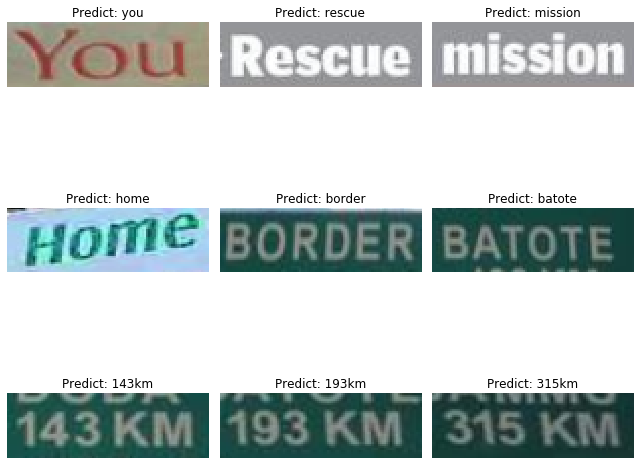

In [243]:
texts = to_string(p, tp)

fig, axes = plt.subplots(3,3,figsize=(9,9))
for i,ax in enumerate(axes.flatten()):    
    ax.imshow(x[i].permute(1,2,0))
    ax.set_title("Predict: %s" % "".join(texts[i]))
    ax.set_axis_off()
plt.tight_layout()